In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

torch.nn es para neural networks
torch.optim es para los optimizadores
torchvision contiene datasets, modelos, y transofrmación de imágenes para vision computacional  
* datasets es para las bases de datos
* transforms es para transformar las imágenes en un formato para entrenamiento
torch.utils.data es una clase que itera la lectura de los datasets

In [3]:
# Configuración de transformación de datos para el conjunto MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalización
])

Se usa compose para hacer varias transformaciones juntas

In [4]:
# Carga del conjunto de datos MNIST
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

Failed to download (trying next):
<urlopen error [WinError 10061] No se puede establecer una conexión ya que el equipo de destino denegó expresamente dicha conexión>



100%|██████████| 9.91M/9.91M [00:01<00:00, 6.35MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10061] No se puede establecer una conexión ya que el equipo de destino denegó expresamente dicha conexión>



100%|██████████| 28.9k/28.9k [00:00<00:00, 408kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10061] No se puede establecer una conexión ya que el equipo de destino denegó expresamente dicha conexión>



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.63MB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
<urlopen error [WinError 10061] No se puede establecer una conexión ya que el equipo de destino denegó expresamente dicha conexión>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.64MB/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [5]:
# Dividir el conjunto de entrenamiento en entrenamiento y validación
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [6]:
# Crear cargadores de datos
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [7]:
# Definir el modelo de red neuronal
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], output_size)
        self.activation = nn.Sigmoid()  # Activación Sigmoid
        self.softmax = nn.Softmax(dim=1)  # Softmax para salida

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

Primera gran diferencia, PyTorch suele tener una estructura más compleja por el uso de clases e iniciadores mientras que keras es más intuitivo y las propiedades se le atribuyen directamente a la variable.

In [8]:
# Instanciar el modelo
input_size = 28 * 28
hidden_sizes = [784, 30]
output_size = 10

model = NeuralNetwork(input_size, hidden_sizes, output_size)

In [9]:
# Configurar el optimizador y la función de pérdida
custom_optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9, eps=1e-09)
criterion = nn.CrossEntropyLoss()  # Pérdida para clasificación

In [10]:
# Definir función para entrenar el modelo
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.view(images.size(0), -1)  # Aplanar las imágenes

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validación
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.view(images.size(0), -1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return train_losses, val_losses

In [11]:
# Función para evaluar el modelo
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.view(images.size(0), -1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Test Loss: {test_loss / len(test_loader):.4f}, Accuracy: {accuracy:.4f}")
    return accuracy

In [12]:
# Entrenar el modelo
epochs = 30
train_losses, val_losses = train_model(model, train_loader, val_loader, custom_optimizer, criterion, epochs)

Epoch 1/30, Loss: 1.6476, Val Loss: 1.5465
Epoch 2/30, Loss: 1.5343, Val Loss: 1.5212
Epoch 3/30, Loss: 1.5182, Val Loss: 1.5256
Epoch 4/30, Loss: 1.5082, Val Loss: 1.5044
Epoch 5/30, Loss: 1.5032, Val Loss: 1.5052
Epoch 6/30, Loss: 1.4987, Val Loss: 1.5065
Epoch 7/30, Loss: 1.4952, Val Loss: 1.5023
Epoch 8/30, Loss: 1.4930, Val Loss: 1.5035
Epoch 9/30, Loss: 1.4906, Val Loss: 1.5002
Epoch 10/30, Loss: 1.4886, Val Loss: 1.5090
Epoch 11/30, Loss: 1.4874, Val Loss: 1.4957
Epoch 12/30, Loss: 1.4859, Val Loss: 1.5050
Epoch 13/30, Loss: 1.4846, Val Loss: 1.4932
Epoch 14/30, Loss: 1.4835, Val Loss: 1.4924
Epoch 15/30, Loss: 1.4824, Val Loss: 1.4947
Epoch 16/30, Loss: 1.4811, Val Loss: 1.4943
Epoch 17/30, Loss: 1.4814, Val Loss: 1.4945
Epoch 18/30, Loss: 1.4805, Val Loss: 1.4947
Epoch 19/30, Loss: 1.4804, Val Loss: 1.4911
Epoch 20/30, Loss: 1.4794, Val Loss: 1.4917
Epoch 21/30, Loss: 1.4791, Val Loss: 1.4952
Epoch 22/30, Loss: 1.4785, Val Loss: 1.4927
Epoch 23/30, Loss: 1.4778, Val Loss: 1.49

In [13]:
# Evaluar el modelo en el conjunto de prueba
accuracy = evaluate_model(model, test_loader, criterion)

Test Loss: 1.4876, Accuracy: 0.9737


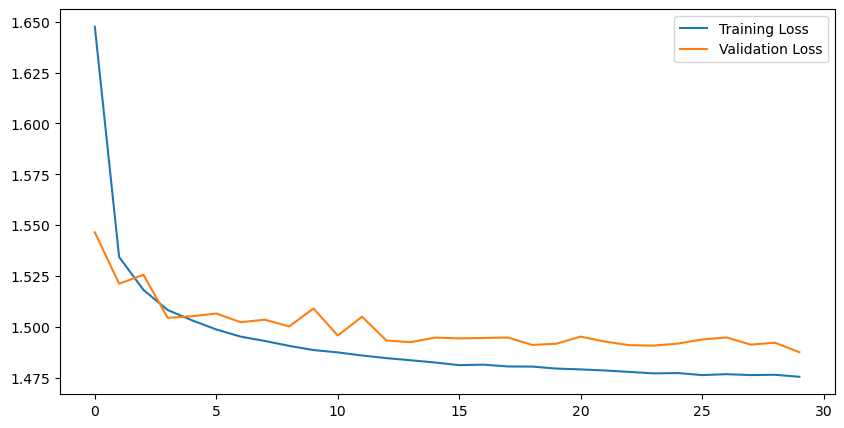

In [14]:
# Graficar las pérdidas
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.show()

In [ ]:
# Guardar y cargar el modelo
torch.save(model.state_dict(), "model.pth")
loaded_model = NeuralNetwork(input_size, hidden_sizes, output_size)
loaded_model.load_state_dict(torch.load("model.pth"))